# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [2]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

In [3]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [4]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables que pueden ser útiles para el modelo

In [5]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,0,0,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,0,4,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,3,3,win


In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48532 non-null  datetime64[ns]
 1   home_team    48532 non-null  object        
 2   away_team    48532 non-null  object        
 3   home_score   48532 non-null  int64         
 4   away_score   48532 non-null  int64         
 5   tournament   48532 non-null  object        
 6   city         48532 non-null  object        
 7   country      48532 non-null  object        
 8   neutral      48532 non-null  bool          
 9   year         48532 non-null  int32         
 10  month        48532 non-null  int32         
 11  goal_diff    48532 non-null  int64         
 12  total_score  48532 non-null  int64         
 13  result       48532 non-null  object        
dtypes: bool(1), datetime64[ns](1), int32(2), int64(4), object(6)
memory usage: 4.5+ MB


In [7]:
results.describe()

,date,home_score,away_score,year,month,goal_diff,total_score
count,48532,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000
mean,1993-10-17 04:11:45.579823488,1.758180,1.181550,1993.265557,6.883664,1.716208,2.939730
min,1872-11-30 00:00:00,0.000000,0.000000,1872.000000,1.000000,0.000000,0.000000
25%,1980-02-27 00:00:00,1.000000,0.000000,1980.000000,4.000000,1.000000,1.000000
50%,2000-03-15 00:00:00,1.000000,1.000000,2000.000000,7.000000,1.000000,3.000000
75%,2012-11-07 06:00:00,2.000000,2.000000,2012.000000,10.000000,2.000000,4.000000
max,2025-09-09 00:00:00,31.000000,21.000000,2025.000000,12.000000,31.000000,31.000000
std,NaN,1.773101,1.400946,25.301688,3.228533,1.791796,2.095142


Visualizaciones de variables numéricas

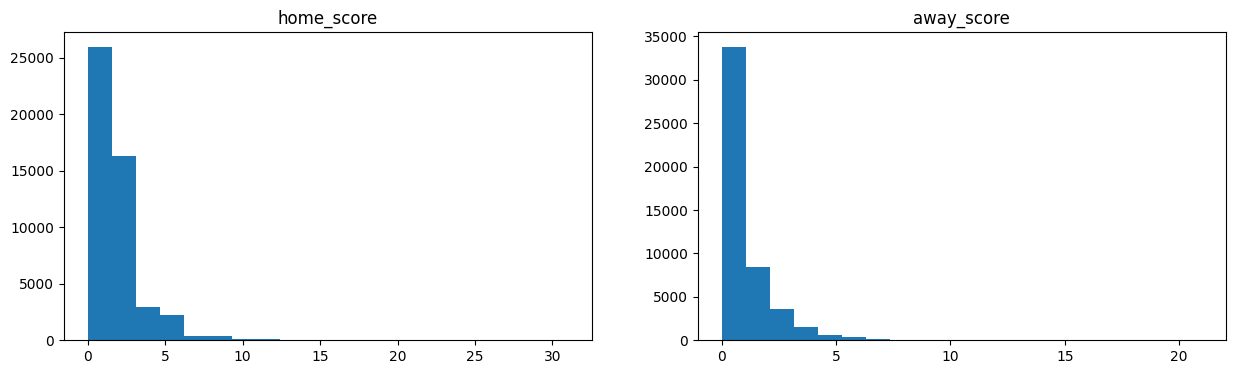

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

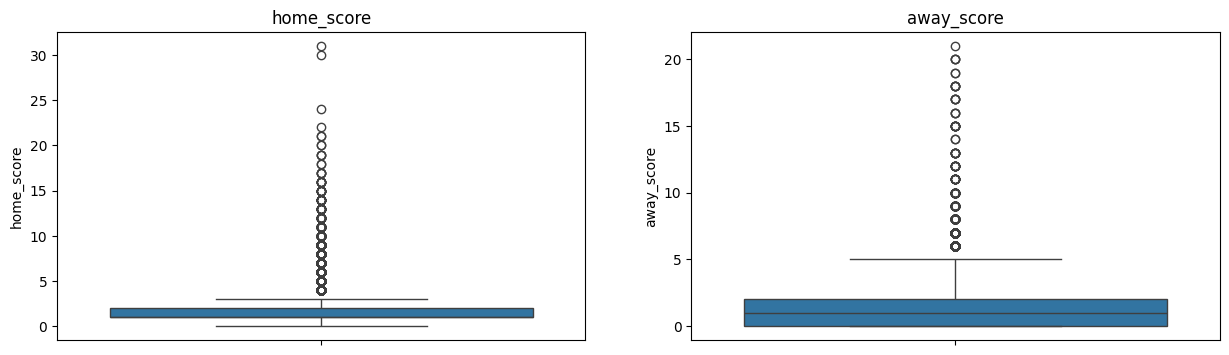

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

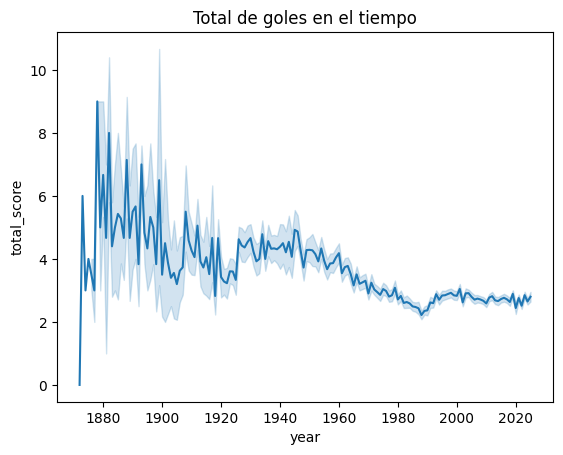

In [10]:
sns.lineplot(data=results, x="year", y="total_score")
plt.title("Total de goles en el tiempo")
plt.show()

Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

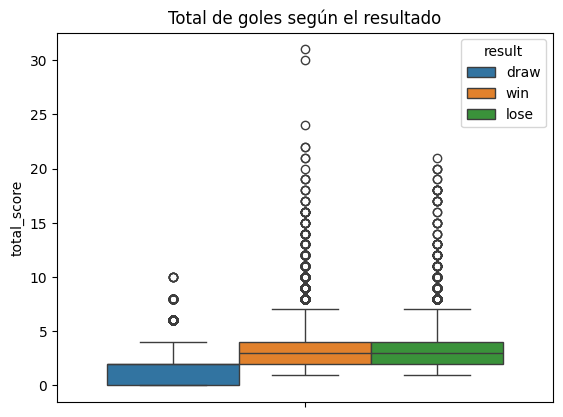

In [11]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

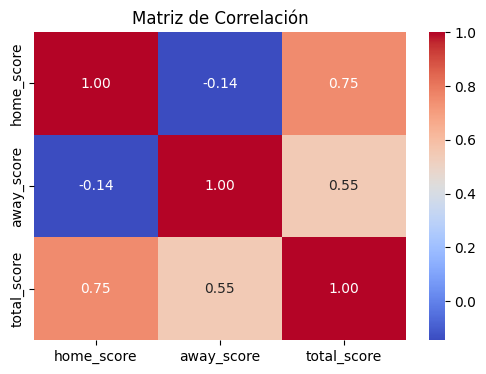

In [12]:
corr = results[["home_score", "away_score", "total_score"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Visualización de variables categoricas

In [13]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')

In [14]:
results.describe(include='category')

,home_team,away_team,tournament,city,country,result
count,48532,48532,48532,48532,48532,48532
unique,325,318,188,2115,268,3
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,win
freq,608,578,18116,736,1458,23797


Veamos la distribución del target

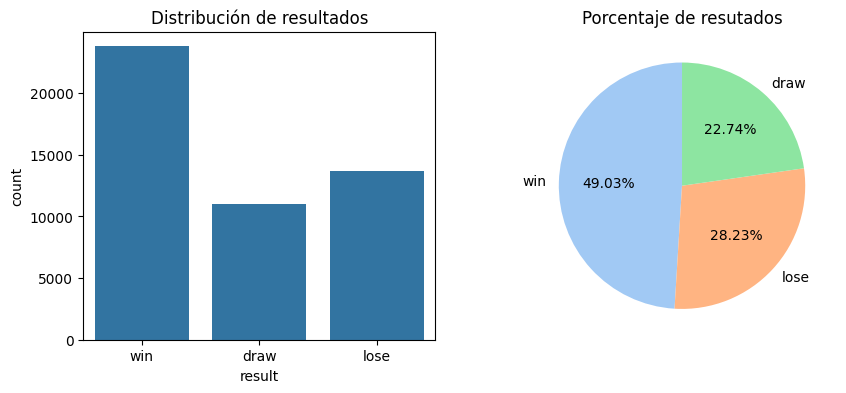

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

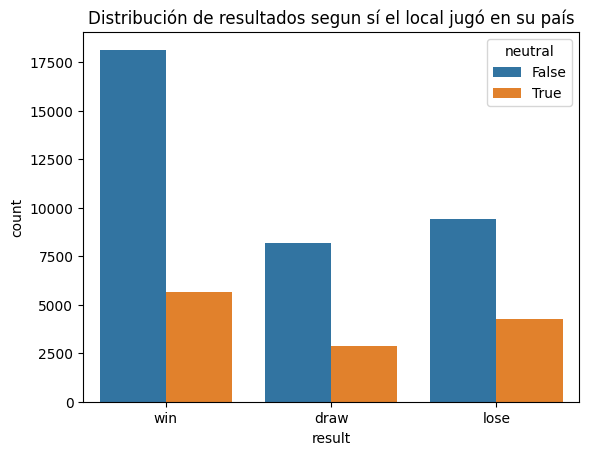

In [16]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()


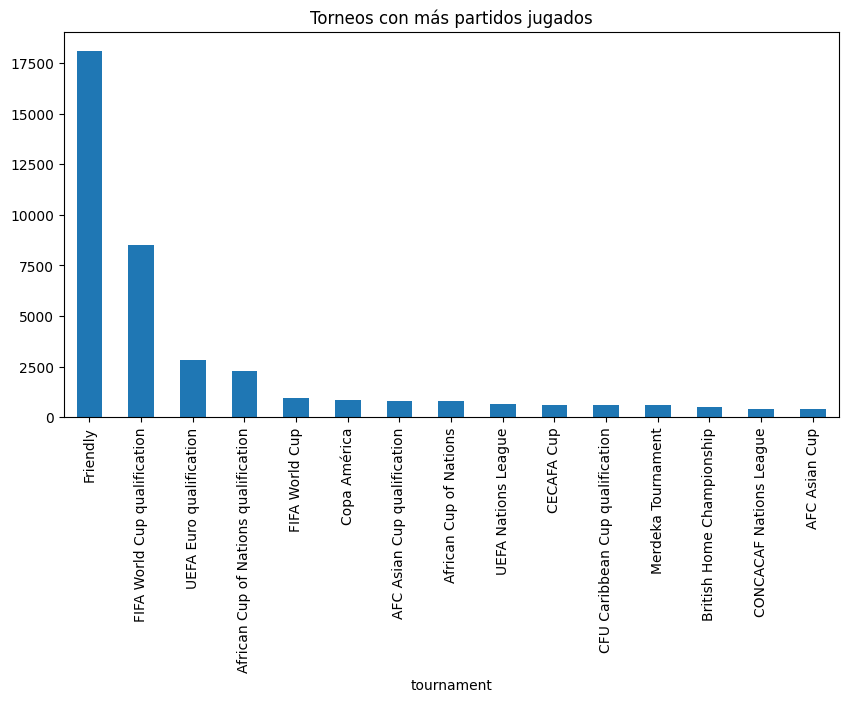

In [17]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(15).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

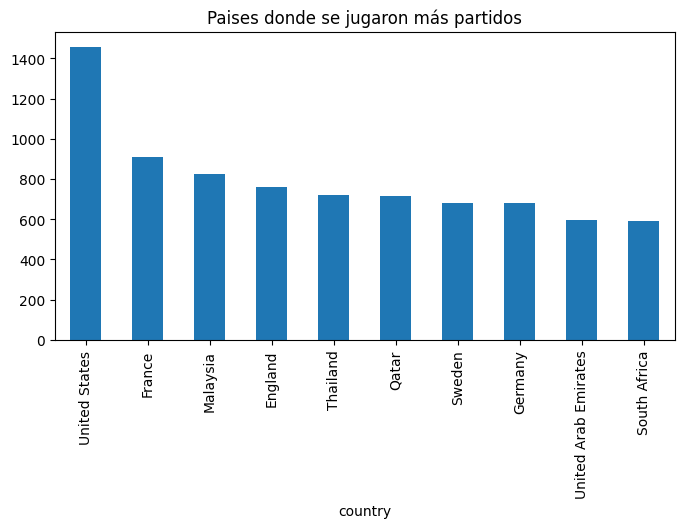

In [18]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

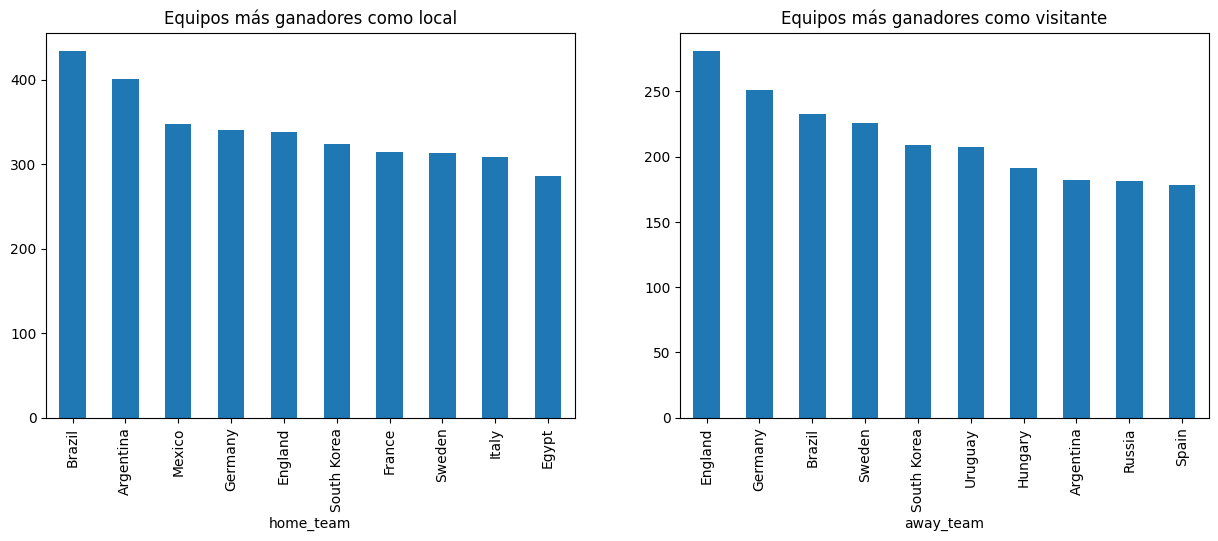

In [19]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

Antes que nada se eliminan los partidos amistosos del dataset, ya que pueden introducir ruido en el modelo. Estos partidos no se juegan con la misma intensidad que los partidos oficiales (suele haber muchos cambios en los equipos, menor motivación, se juega entre equipos de distinto nivel técnico, etc).

**¿Tambien deberiamos considerar solo los torneos mas importantes o mas conocidos?**

In [20]:
results_filtered = results[results["tournament"] != "Friendly"].reset_index(drop=True)

Como el objetivo es predecir el resultado del partido, no podemos usar los datos actuales ya que estos son posteriores al partido. Por lo tanto, se crean nuevas variables que representen el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*. Por ejemplo:
- Tasa de partidos ganados en los últimos N partidos
- Promedio de goles a favor y en contra en los últimos N partidos

In [21]:
window_size = 10  # cantidad de partidos a considerar

# Calcular winrate del equipo local
results_filtered["home_n_winrate"] = (
    results_filtered.groupby("home_team")["result"]
      .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular winrate del equipo visitante
results_filtered['away_n_winrate'] = (
    results_filtered.groupby('away_team')['result']
      .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)


# Promedio de goles a favor
results_filtered['home_n_avg_gf'] = (
    results_filtered.groupby('home_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_gf'] = (
    results_filtered.groupby('away_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Promedio de goles en contra
results_filtered['home_n_avg_ga'] = (
    results_filtered.groupby('home_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_ga'] = (
    results_filtered.groupby('away_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

/tmp/ipykernel_651321/2586177956.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby("home_team")["result"]
/tmp/ipykernel_651321/2586177956.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby('away_team')['result']
/tmp/ipykernel_651321/2586177956.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby('home_team')['home_score']
/tmp/ipykernel_6513

In [22]:
results_filtered.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,goal_diff,total_score,result,home_n_winrate,away_n_winrate,home_n_avg_gf,away_n_avg_gf,home_n_avg_ga,away_n_avg_ga
30411,2025-09-09,Bosnia and Herzegovina,Austria,1,2,FIFA World Cup qualification,Zenica,Bosnia and Herzegovina,False,2025,9,1,3,lose,0.3,0.7,0.9,2.0,1.8,0.9
30412,2025-09-09,Cyprus,Romania,2,2,FIFA World Cup qualification,Nicosia,Cyprus,False,2025,9,0,4,draw,0.3,0.5,0.7,1.9,2.0,1.0
30413,2025-09-09,Norway,Moldova,11,1,FIFA World Cup qualification,Oslo,Norway,False,2025,9,10,12,win,0.7,0.4,2.2,0.7,1.0,1.0
30414,2025-09-09,Albania,Latvia,1,0,FIFA World Cup qualification,Tirana,Albania,False,2025,9,1,1,win,0.4,0.1,1.1,0.5,0.4,2.2
30415,2025-09-09,Serbia,England,0,5,FIFA World Cup qualification,Belgrade,Serbia,False,2025,9,5,5,lose,0.5,0.6,1.5,1.6,0.6,0.7


In [23]:
results_filtered.isna().sum()[results_filtered.isna().sum() > 0]

home_n_avg_gf    304
away_n_avg_gf    298
home_n_avg_ga    304
away_n_avg_ga    298
dtype: int64

En base al procesamiento realizado, aparecen valores nulos en el promedio de goles a favor y en contra. Se decide imputar estos valores con 1.

In [24]:
features_nulls = [
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
]

results_filtered[features_nulls] = results_filtered[features_nulls].fillna(1.0)

Codificamos las variables categoricas:
- result se codifica con LabelEncoder por ser la variable a predecir
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta (**posible leakage?**)

In [25]:
result_encoder = LabelEncoder()
results_filtered["result_enc"] = result_encoder.fit_transform(results_filtered["result"])

tournament_encoder = TargetEncoder()
results_filtered["tournament_enc"] = tournament_encoder.fit_transform(results_filtered["tournament"], results_filtered["result_enc"])

home_team_encoder = TargetEncoder()
results_filtered["home_team_enc"] = home_team_encoder.fit_transform(results_filtered["home_team"], results_filtered["result_enc"])

away_team_encoder = TargetEncoder()
results_filtered["away_team_enc"] = away_team_encoder.fit_transform(results_filtered["away_team"], results_filtered["result_enc"])

results_filtered["neutral"] = results_filtered["neutral"].astype(int)

In [26]:
print(results_filtered[["result", "result_enc"]])

      result  result_enc
0       lose           1
1        win           2
2       lose           1
3        win           2
4       lose           1
...      ...         ...
30411   lose           1
30412   draw           0
30413    win           2
30414    win           2
30415   lose           1

[30416 rows x 2 columns]


Como el resultado de un partido puede estar influenciado por resultados anteriores (no es lo mismo enfrentar al último campeón del mundo), se decide tratar al dataset como una serie temporal. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada.

In [27]:
train = results_filtered[results_filtered["date"] < "2015-01-01"]
test = results_filtered[results_filtered["date"] >= "2015-01-01"]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (23106, 24)
Test shape: (7310, 24)


In [28]:
# Definimos las features que usaremos para el modelo:
features = [
    'home_n_winrate', 'away_n_winrate',
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
    'neutral', 'tournament_enc',
    'home_team_enc', 'away_team_enc'
]

target = "result_enc"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

Escalamos las variables para que todas esten en la misma escala.

In [29]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [30]:
# Función: calcula estadísticas recientes por equipo
# def compute_team_form(df, team, date, window_years=3):
#     """Devuelve winrate, goles a favor y goles en contra promedio
#     de un equipo en los últimos window_years años antes de 'date'."""
#     cutoff = date - pd.DateOffset(years=window_years)
#     past_matches = df[
#         ((df["home_team"] == team) | (df["away_team"] == team)) &
#         (df["date"] < date) &
#         (df["date"] >= cutoff)
#     ]
#     if past_matches.empty:
#         return pd.Series([0.5, 1.0, 1.0])  # valores neutros de winrate, promedio de goles a favor y goles en contra
    
#     # resultados desde perspectiva del team
#     wins, draws, losses, gf, ga = 0, 0, 0, 0, 0
#     for _, row in past_matches.iterrows():
#         if row["home_team"] == team:
#             gf += row["home_score"]
#             ga += row["away_score"]
#             if row["home_score"] > row["away_score"]:
#                 wins += 1
#             elif row["home_score"] == row["away_score"]:
#                 draws += 1
#             else:
#                 losses += 1
#         else:  # team fue visitante
#             gf += row["away_score"]
#             ga += row["home_score"]
#             if row["away_score"] > row["home_score"]:
#                 wins += 1
#             elif row["away_score"] == row["home_score"]:
#                 draws += 1
#             else:
#                 losses += 1
    
#     total = wins + draws + losses
#     winrate = wins / total if total > 0 else 0.5
#     avg_gf = gf / total if total > 0 else 1.0
#     avg_ga = ga / total if total > 0 else 1.0
    
#     return pd.Series([winrate, avg_gf, avg_ga])


In [31]:
# Crear features de fuerza para cada partido
# features = []
# for idx, row in results.iterrows():
#     home_stats = compute_team_form(results, row["home_team"], row["date"], window_years=3)
#     away_stats = compute_team_form(results, row["away_team"], row["date"], window_years=3)
    
#     features.append([
#         row["home_team"], row["away_team"], row["date"], row["result"],
#         home_stats[0], home_stats[1], home_stats[2],
#         away_stats[0], away_stats[1], away_stats[2]
#     ])

# df_feat = pd.DataFrame(features, columns=[
#     "home_team","away_team","date","result",
#     "home_winrate","home_gf","home_ga",
#     "away_winrate","away_gf","away_ga"
# ])

# print(df_feat.head())

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

In [32]:

# # Copiamos df_feat y preparamos target
# df_model = df_feat.copy()

# # Encode target (win/draw/loss)
# le_result = LabelEncoder()
# df_model["target_enc"] = le_result.fit_transform(df_model["result"])
# print("Classes:", le_result.classes_)

# # Features: fuerza de cada equipo
# X = df_model[[
#     "home_winrate", "home_gf", "home_ga",
#     "away_winrate", "away_gf", "away_ga"
# ]]
# y = df_model["target_enc"]

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, shuffle=True, random_state=42
# )

# # Modelo baseline: regresión logística multiclase
# logreg = LogisticRegression(max_iter=1000)  # multinomial por default desde sklearn 1.5
# logreg.fit(X_train, y_train)

# # Predicciones
# y_pred = logreg.predict(X_test)
# y_prob = logreg.predict_proba(X_test)


# # Métricas
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Log Loss:", log_loss(y_test, y_prob))

# print("\nClassification Report:\n", 
#       classification_report(y_test, y_pred, 
#                           target_names=le_result.classes_,
#                           zero_division=0))

# cm = confusion_matrix(y_test, y_pred)

# sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=False)

# plt.tight_layout()
# plt.show()


Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.34      0.30      1595
        lose       0.55      0.57      0.56      2261
         win       0.71      0.62      0.66      3454

    accuracy                           0.54      7310
   macro avg       0.51      0.51      0.51      7310
weighted avg       0.57      0.54      0.55      7310



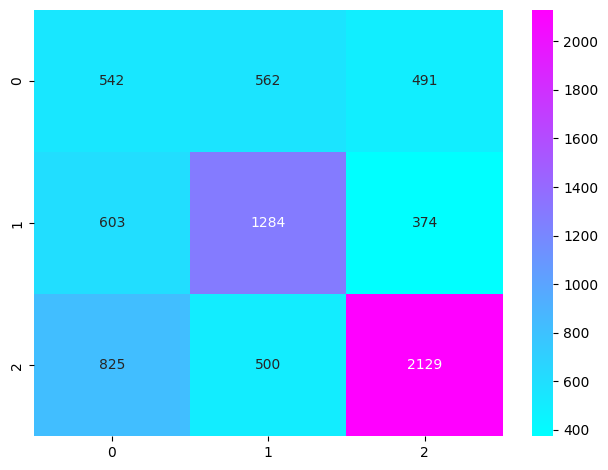

In [33]:
# Modelo baseline: regresión logística multiclase
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("\nClassification Report:\n", 
      classification_report(y_test, y_pred, 
                          target_names=result_encoder.classes_,
                          zero_division=0))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True)

plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.17      0.21      1595
        lose       0.52      0.50      0.51      2261
         win       0.61      0.74      0.67      3454

    accuracy                           0.54      7310
   macro avg       0.47      0.47      0.47      7310
weighted avg       0.51      0.54      0.52      7310



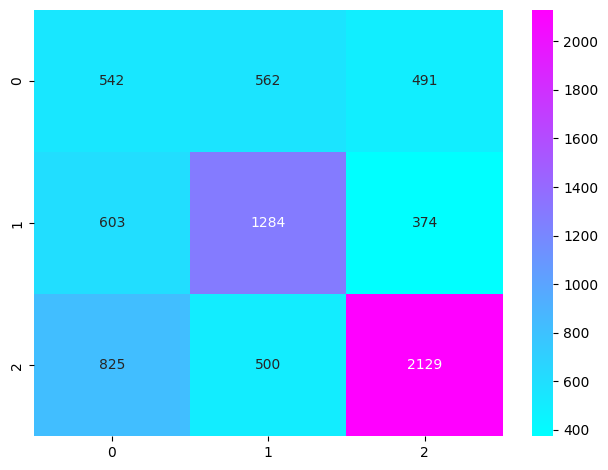

In [34]:
# KNN
classifier_knn = KNeighborsClassifier(n_neighbors=10, metric="minkowski", p=2)
classifier_knn.fit(X_train, y_train)

y_pred  = classifier_knn.predict(X_test)

print("\nClassification Report:\n", 
      classification_report(y_test, y_pred, 
                          target_names=result_encoder.classes_,
                          zero_division=0))

cm_knn = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True)

plt.tight_layout()
plt.show()

In [ ]:
svc = SVC(C=5, kernel="linear", decision_function_shape='ovo', probability=True)
svc.fit(X_train, y_train)

y_pred  = svc.predict(X_test)

print("\nClassification Report:\n", 
      classification_report(y_test, y_pred, 
                          target_names=result_encoder.classes_,
                          zero_division=0))

cm_knn = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True)

plt.tight_layout()
plt.show()

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.